### Shivanka Priyashan
### Index No : 190476V

#### Question 01

In [9]:
import numpy as np
import cv2 as cv
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt

N = 100
half_n = N//2
r = 10
s = r /16
t = np.random.uniform (0 , 2*np.pi , half_n )
n = s*np.random.randn( half_n )
x , y = (r + n)*np.cos(t) , (r + n)*np.sin(t)
X_circ = np.hstack(( x.reshape(half_n , 1 ) , y.reshape (half_n , 1 )))
m, b = -1, 2
x = np.linspace (-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )
X_line = np.hstack(( x.reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
X = np.vstack ( ( X_line ,X_circ  ) )

# plt.figure(figsize=(16,16))
# for point in X:
#    plt.scatter(point[0],point[1])
#    plt.axis("equal")
# plt.show()

In [30]:
import random

def circle_from3points(pointSet,N_num,thresh):

    max_inlier_count = 0
    for i in range(iter_num):
        #Obtain index of 3 random points
        point1, point2, point3 = random.randint(0,len(pointSet)-1), random.randint(0,len(pointSet)-1),random.randint(0,len(pointSet)-1)
        x1,x2,x3 = pointSet[point1][0], pointSet[point2][0], pointSet[point3][0]
        y1,y2,y3 = pointSet[point1][1], pointSet[point2][1], pointSet[point3][1]

        A = np.array([[(x1**2 + y1**2), x1, y1, 1], [(x2**2 + y2**2), x2, y2, 1], [(x3**2 + y3**2), x3, y3, 1]])
        M_11 = np.linalg.det(A[:,1:])
        if M_11 == 0 : continue
        M_12 = np.linalg.det(np.concatenate((A[:,0].reshape((3,1)),A[:,2:].reshape((3,2))),axis = 1))     
        M_13 = np.linalg.det(np.concatenate((A[:,:2].reshape((3,2)),A[:,3].reshape((3,1))),axis = 1))   
        M_14 = np.linalg.det(A[:,:3])
        x0 = (1/2)*(M_12/M_11)
        y0 = (-1/2)*(M_13/M_11)
        r = np.sqrt(x0**2 + y0**2 + abs(M_14/M_11))

        if r > 10 : continue
        
        inlier_count, outlier_count = 0, 0
        inlier_points, outlier_points = [],[]
        
        for j in range(len(pointSet)):
            point = pointSet[j]
            x,y = point[0], point[1]
            distance = abs(np.sqrt((x - x0)**2 + (y - y0)**2) - r) 
            if distance < thresh:
                inlier_count+=1
                inlier_points.append(point)
            else:
                outlier_count+=1
                outlier_points.append(point)

        if inlier_count > max_inlier_count:
            max_inlier_count = inlier_count
            attr = [x0,y0,r]
            best_fit_pts = np.array([pointSet[point1],pointSet[point2],pointSet[point3]]).T
            selected_inliers = np.array(inlier_points).T
            selected_outliers = np.array(outlier_points).T

    return max_inlier_count, attr, best_fit_pts, selected_inliers, selected_outliers

Number of iterations:  34
RANSAC Inlier count:  48


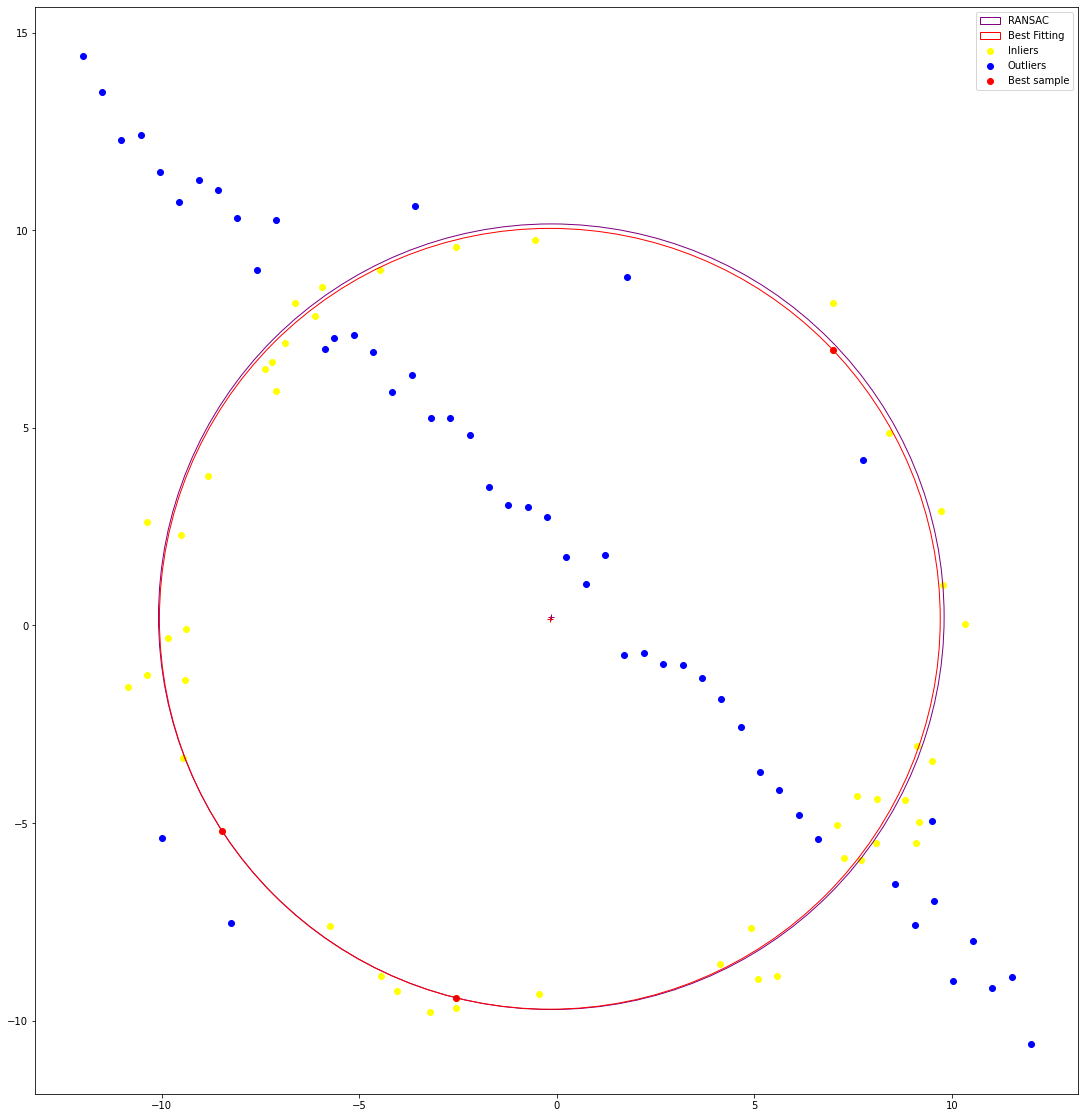

In [54]:
s = 3
t = 1                                       #threshold
e = 0.5                                     #outlier ratio
p = 0.99                                    #probability that at least one sample is free from outliers
N  = int(np.log(1-p)/ np.log(1-(1-e)**s))

fig, ax = plt.subplots(1,figsize=(20,20))

#######  RANSAC circle #########
RANSAC_inlier_count, RANSAC_circle_attr, best_fit_pts, RANSAC_selected_inliers, RANSAC_selected_outliers = circle_from3points(X,N,t)
####### Best fitting circle ########
bestFitInlierCount, bestFitCircleAttr, bestFitPts, bestFitSI, bestFitSO = circle_from3points(RANSAC_selected_inliers.T,12000,t)


RANSAC_circle = plt.Circle((RANSAC_circle_attr[0],RANSAC_circle_attr[1]),RANSAC_circle_attr[2],fill=False,color='purple',label='RANSAC')
ax.add_patch(RANSAC_circle)
ax.plot(RANSAC_circle_attr[0],RANSAC_circle_attr[1],'+',color='purple')
ax.scatter(RANSAC_selected_inliers[0],RANSAC_selected_inliers[1],color='yellow',label='Inliers')
ax.scatter(RANSAC_selected_outliers[0],RANSAC_selected_outliers[1],color='blue',label='Outliers')

bestfit_circle = plt.Circle((bestFitCircleAttr[0],bestFitCircleAttr[1]),bestFitCircleAttr[2],fill=False,color='red',label='Best Fitting')
ax.add_patch(bestfit_circle)
ax.plot(bestFitCircleAttr[0],bestFitCircleAttr[1],'+',color='red')
ax.scatter(bestFitPts[0],bestFitPts[1],color='red', label='Best sample')

print('Number of iterations: ',N)
print('RANSAC Inlier count: ',RANSAC_inlier_count)

ax.set_aspect('equal')
plt.legend(loc='upper right')
plt.show()

#### Question 02

##### Computing Homography

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def MouseClick(event,x,y,flag,param):
    global im_temp, pts_dst
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(im_temp, (x,y), 2, (0,0,255), 3, cv.LINE_AA)
        cv.imshow('Image',im_temp)
        if len(pts_dst) < 4:
            pts_dst = np.append(pts_dst,[(x,y)],axis=0)

def Homography(dst, src, alpha, beta):
    global im_temp, pts_dst
    dst_img = cv.imread(dst)
    dst_img_RGB = cv.cvtColor(dst_img,cv.COLOR_BGR2RGB)

    flag = cv.imread(src)
    flag_RGB = cv.cvtColor(flag,cv.COLOR_BGR2RGB)

    assert dst_img is not None
    assert flag is not None

    im_temp = dst_img.copy()

    pts_dst = np.empty((0,2))
    print(pts_dst)

    cv.namedWindow('Image',1)
    cv.imshow('Image',im_temp)
    cv.setMouseCallback("Image", MouseClick)
    cv.waitKey(0)

    bh, bw = dst_img.shape[0], dst_img.shape[1]
    fh, fw = flag.shape[0], flag.shape[1]

    pts_src = np.array([[0,0],[fw-1,0],[fw-1,fh-1],[0,fh-1]])

    hmg_matrix, status = cv.findHomography(pts_src, pts_dst)

    transformed_flag = cv.warpPerspective(flag, hmg_matrix, (bw,bh))    
    transformed_flag_RGB = cv.cvtColor(transformed_flag,cv.COLOR_BGR2RGB)

    blended_image = cv.addWeighted(dst_img,alpha,transformed_flag,beta,0.0)

    blended_image_RGB = cv.cvtColor(blended_image,cv.COLOR_BGR2RGB)

    fig, ax = plt.subplots(4,1,figsize=(20,20))

    ax[0].imshow(dst_img_RGB)
    ax[0].set_title('Destination image')
    ax[0].axis('off')

    ax[1].imshow(flag_RGB)
    ax[1].set_title('Source image')
    ax[1].axis('off')

    ax[2].imshow(transformed_flag_RGB)
    ax[2].set_title('Warped image')
    ax[2].axis('off')

    ax[3].imshow(blended_image_RGB)
    ax[3].set_title('Blended image')
    ax[3].axis('off')

    plt.show()
    cv.imwrite('Blended image.jpg',blended_image)

    return 'Blended image.jpg'

[]


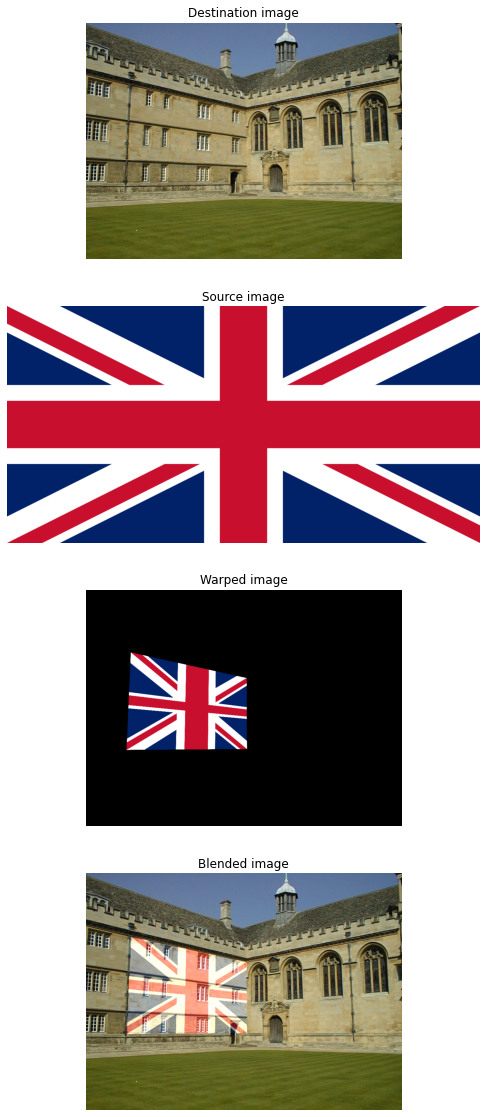

In [3]:
out1 = Homography('001.jpg','flag_uk.png',1,0.5)

[]


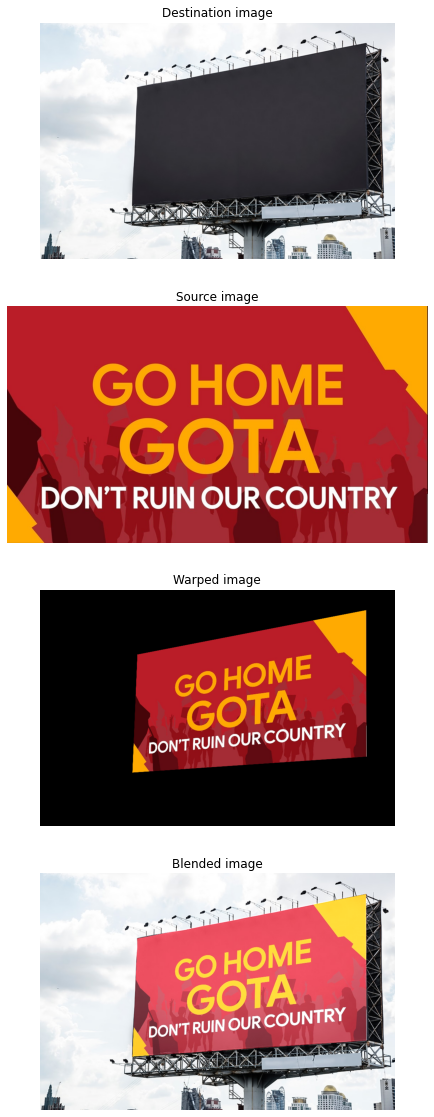

In [4]:
out2 = Homography('billboard_black.jpg','gotagohome.jpg',1,1)

[]


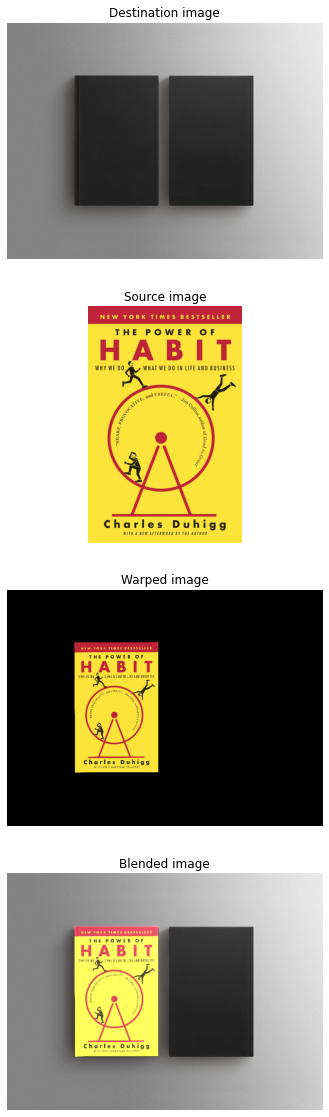

[]


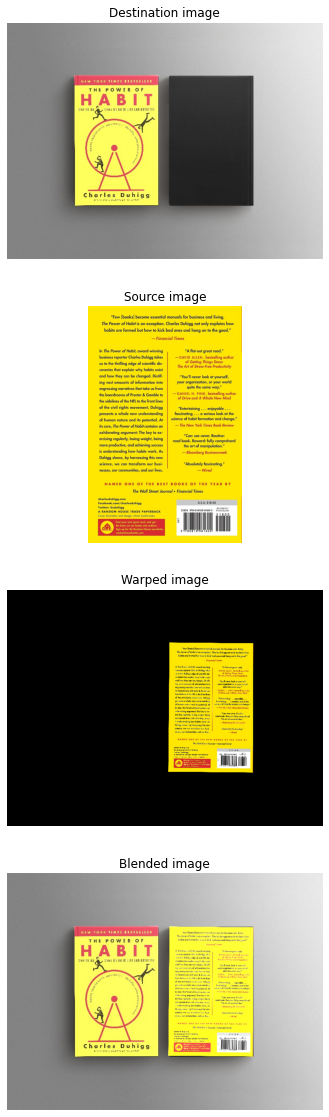

In [5]:
#Applying homography on the output of first homography

out3 = Homography(Homography('book.jpg','book_Front.jpg',1,1),'book_back.jpg',1,1)

#### Question 03

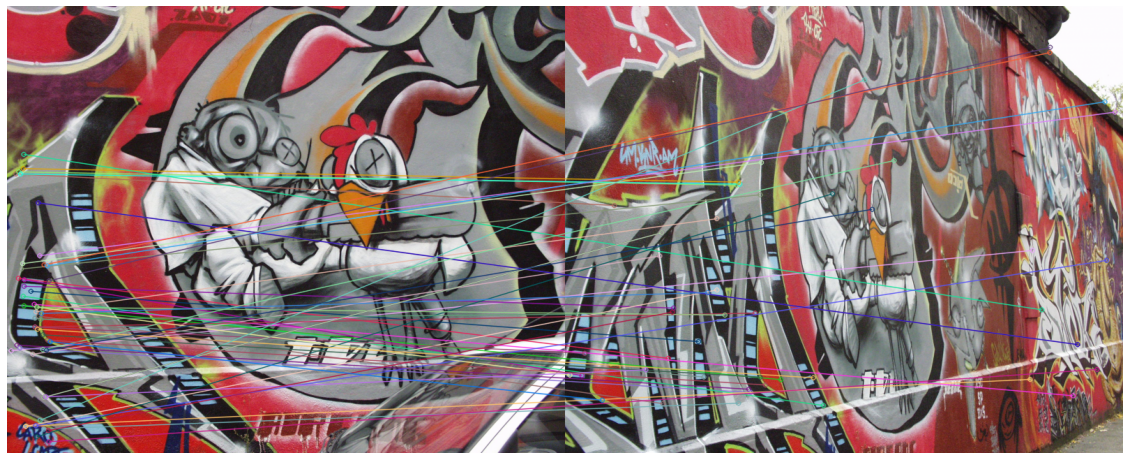

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

img1 = cv.imread('graf\img1.ppm')
img2 = cv.imread('graf\img2.ppm')
img3 = cv.imread('graf\img3.ppm')
img4 = cv.imread('graf\img4.ppm')
img5 = cv.imread('graf\img5.ppm')

img1_rgb = cv.cvtColor(img1,cv.COLOR_BGR2RGB)
img5_rgb = cv.cvtColor(img5,cv.COLOR_BGR2RGB)

assert img1 is not None
assert img5 is not None

#Feature detection from the image

sift = cv.SIFT_create(nOctaveLayers=3,contrastThreshold=0.1,edgeThreshold=25,sigma=1)

keypoints_1, descriptors_1 = sift.detectAndCompute(img1_rgb,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img5_rgb,None)

#Draw the detected keypoints

bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
matches = bf.match(descriptors_1,descriptors_2)
matched_img = cv.drawMatches(img1_rgb, keypoints_1, img5_rgb, keypoints_2, matches[:50], img5, flags=2)

matches = sorted(matches, key = lambda x:x.distance)

plt.figure(figsize=(20,18))
plt.imshow(matched_img)
plt.axis('off')
plt.show()

In [2]:
def homography_RANSAC(sourcePoints,destinationPoints):
    N = 500
    t = 1
    maxInliers = []
    finalH = None

    for i in range(N):
        p = np.random.randint(0,len(sourcePoints)) 
        q = np.random.randint(0,len(sourcePoints))
        r = np.random.randint(0,len(sourcePoints))
        s = np.random.randint(0,len(sourcePoints))
        
        P = [sourcePoints[p][0][0],sourcePoints[p][0][1],destinationPoints[p][0][0],destinationPoints[p][0][1]]
        Q = [sourcePoints[q][0][0],sourcePoints[q][0][1],destinationPoints[q][0][0],destinationPoints[q][0][1]]            
        x = np.vstack((P,Q))
        R = [sourcePoints[r][0][0],sourcePoints[r][0][1],destinationPoints[r][0][0],destinationPoints[r][0][1]]
        x = np.vstack((x,R))
        S = [sourcePoints[s][0][0],sourcePoints[s][0][1],destinationPoints[s][0][0],destinationPoints[s][0][1]]
        x = np.vstack((x,S))
        
        aList = []
        for corr in x:
            p1 = np.matrix([corr.item(0), corr.item(1), 1])
            p2 = np.matrix([corr.item(2), corr.item(3), 1])

            a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2)*p1.item(1), -p2.item(2)*p1.item(2),
                  p2.item(1)*p1.item(0), p2.item(1)*p1.item(1), p2.item(1)*p1.item(2)]
            a1 = [-p2.item(2)*p1.item(0), -p2.item(2)*p1.item(1), -p2.item(2)*p1.item(2), 0, 0, 0,
                  p2.item(0)*p1.item(0), p2.item(0)*p1.item(1), p2.item(0)*p1.item(2)]
            aList.append(a1)
            aList.append(a2)

        matrixA = np.matrix(aList)

        u, s, v = np.linalg.svd(matrixA)

        H = np.reshape(v[8], (3, 3))
        H = (1/H.item(8)) * H
        inliers = []
        for k in range(len(sourcePoints)):
            
            d = geometricDistance([sourcePoints[k][0][0],sourcePoints[k][0][1],destinationPoints[k][0][0],destinationPoints[k][0][1]], H)
            if d < t:
                inliers.append([sourcePoints[k][0][0],sourcePoints[k][0][1],destinationPoints[k][0][0],destinationPoints[k][0][1]])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = H


    maxInliers1 = []
    finalH1 = None
    for i in range(N):
            p = np.random.randint(0,len(maxInliers)) 
            q = np.random.randint(0,len(maxInliers))
            r = np.random.randint(0,len(maxInliers))
            s = np.random.randint(0,len(maxInliers))
            
            P = [maxInliers[p][0],maxInliers[p][1],maxInliers[p][2],maxInliers[p][3]]
            Q = [maxInliers[q][0],maxInliers[q][1],maxInliers[q][2],maxInliers[q][3]]            
            x = np.vstack((P,Q))
            R = [maxInliers[r][0],maxInliers[r][1],maxInliers[r][2],maxInliers[r][3]]
            x = np.vstack((x,R))
            S = [maxInliers[s][0],maxInliers[s][1],maxInliers[s][2],maxInliers[s][3]]
            x = np.vstack((x,S))

            aList = []
            for corr in x:
                p1 = np.matrix([corr.item(0), corr.item(1), 1])
                p2 = np.matrix([corr.item(2), corr.item(3), 1])

                a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
                    p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
                a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
                    p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
                aList.append(a1)
                aList.append(a2)

            matrixA = np.matrix(aList)

            u, s, v = np.linalg.svd(matrixA)

            H = np.reshape(v[8], (3, 3))
            H = (1/H.item(8)) * H
            inliers = []
            for k in range(len(maxInliers)):
                
                d = geometricDistance([maxInliers[k][0],maxInliers[k][1],maxInliers[k][2],maxInliers[k][3]], H)
                if d < t:
                    inliers.append([maxInliers[k][0],maxInliers[k][1],maxInliers[k][2],maxInliers[k][3]])
            
            if len(inliers) > len(maxInliers1):
                maxInliers1 = inliers
                finalH1 = H

    return maxInliers,finalH1

In [3]:
def homography(img1,img2):
    sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = .1,edgeThreshold = 25,sigma =1)

    keyPoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keyPoints2, descriptors2 = sift.detectAndCompute(img2, None)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    goodMatches = []
    for m, n in matches:
        if m.distance < 0.95 * n.distance:
            goodMatches.append(m)
    MIN_MATCH_COUNT = 10
    if len(goodMatches) > MIN_MATCH_COUNT:
        sourcePoints = np.float32([keyPoints1[m.queryIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
        destinationPoints = np.float32([keyPoints2[m.trainIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
        maxInliers1,finalH1 = homography_RANSAC(sourcePoints,destinationPoints)

    return finalH1

In [4]:
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0], correspondence[1], 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[2], correspondence[3], 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [7]:
H15_direct  = homography(img1,img5)
print('Homography matrix direclty from 1 to 5\n',H15_direct)

Homography matrix direclty from 1 to 5
 [[5.80166882e+02 6.59397736e+01 2.74966680e+02]
 [9.60326088e+02 1.09147362e+02 4.55140969e+02]
 [2.10995297e+00 2.39810002e-01 1.00000000e+00]]


In [9]:
H12 = homography(img1,img2)
H23 = homography(img2,img3)
H34 = homography(img3,img4)
H45 = homography(img4,img5)

H15 = H45 @ H34 @ H23 @ H12
print('Homography matrix from RANSAC\n',H15)

Homography matrix from RANSAC
 [[ 6.07453093e-01  3.96321736e-02  2.23315371e+02]
 [ 2.17813490e-01  1.12507405e+00 -2.24741958e+01]
 [ 4.77126136e-04 -8.85386419e-05  9.95034226e-01]]


In [47]:
H_dataset = np.array([[6.2544644e-01, 5.7759174e-02, 2.2201217e+02],
                      [2.2240536e-01, 1.1652147e+00,-2.5605611e+01],
                      [4.9212545e-04,-3.6542424e-05, 1.0000000e+00]])

print('Homography matrix from dataset\n',H_dataset)

Homography matrix from dataset
 [[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


In [8]:
img1_warped = cv.warpPerspective(img1,H15,(img5.shape[1],img5.shape[0]))

img1_warped_rgb = cv.cvtColor(img1_warped,cv.COLOR_BGR2RGB)

img1to5_blended = cv.addWeighted(img5,1,img1_warped,0.2,0)

img1to5_blended_rgb = cv.cvtColor(img1to5_blended,cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1,4,figsize=(20,5))

ax[0].imshow(img1_rgb)
ax[0].axis('off')
ax[0].set_title('img1')

ax[1].imshow(img5_rgb)
ax[1].axis('off')
ax[1].set_title('img5')

ax[2].imshow(img1_warped_rgb)
ax[2].axis('off')
ax[2].set_title('img1 warped')

ax[3].imshow(img1to5_blended_rgb)
ax[3].axis('off')
ax[3].set_title('Stitched image')

plt.show()



NameError: name 'H15' is not defined